# Практическая работа №4

### Используемые библиотеки

In [1]:
from math import sqrt, pi, exp

import pandas as pd
from numpy import array, zeros, column_stack
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

### Используемые алгоритмы

In [2]:
def plot_dendrogram(model, **kwargs):
    fig, ax = plt.subplots(1, 1)
    ax.set_yticks([])
    ax.set_xlabel(kwargs.pop("label"))

    counts = zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

    plt.show()

### Исходные данные

`data1.csv`:
```csv
2
4
10
12
3
20
30
11
25
```

`data2.csv`:
```csv
x,p1,p2
2,0.9,0.1
3,0.8,0.1
7,0.3,0.7
9,0.1,0.9
2,0.9,0.1
1,0.8,0.2
```

`data3.csv`:
```csv
x1,x2,x3,x4,x5
1,0,1,1,0
1,1,0,1,0
0,0,1,1,0
0,1,0,1,0
1,0,1,0,1
0,1,1,0,0
```

## Задание 1

In [3]:
frame = pd.read_csv('data1.csv', header=None)
print(f"Исходный набор данных:")
frame

Исходный набор данных:


,0
0,2
1,4
2,10
3,12
4,3
5,20
6,30
7,11
8,25


### Представление данных в виде кластеров

In [4]:
clusters = (2, 4, 6)
reshape = array(clusters).reshape(-1, 1)

dist = pairwise_distances(frame, reshape)
min_dist = pairwise_distances_argmin(frame, reshape)

pd.DataFrame(dist, columns=clusters, index=frame[0].values).assign(cluster=[clusters[i] for i in min_dist])

,2,4,6,cluster
2,0.0,2.0,4.0,2
4,2.0,0.0,2.0,4
10,8.0,6.0,4.0,6
12,10.0,8.0,6.0,6
3,1.0,1.0,3.0,2
20,18.0,16.0,14.0,6
30,28.0,26.0,24.0,6
11,9.0,7.0,5.0,6
25,23.0,21.0,19.0,6


### Первая итерация алгоритма k-means

In [5]:
k_means = KMeans(init=array(clusters).reshape(-1, 1), n_clusters=3, n_init=1)

dist = k_means.fit_transform(frame)
new_clusters = list(map(lambda x: int(x[0]), k_means.cluster_centers_.tolist()))
new_min_dist = pairwise_distances_argmin(frame, k_means.cluster_centers_)
pd.DataFrame(dist, columns=new_clusters, index=frame[0].values).assign(cluster=[new_clusters[i] for i in new_min_dist])

,3,11,25,cluster
2,1.0,9.0,23.0,3
4,1.0,7.0,21.0,3
10,7.0,1.0,15.0,11
12,9.0,1.0,13.0,11
3,0.0,8.0,22.0,3
20,17.0,9.0,5.0,25
30,27.0,19.0,5.0,25
11,8.0,0.0,14.0,11
25,22.0,14.0,0.0,25


### Выводы

In [6]:
print("Кластеры, полученные после 0й итерации:")
for index, cluster in enumerate(clusters):
    print(f"Кластер №{index + 1} с центром в {cluster}: {[v for i, v in enumerate(frame[0].values) if min_dist[i] == index]}")

print("\nКластеры, полученные после 1й итерации:")
for index, cluster in enumerate(new_clusters):
    print(f"Кластер №{index + 1} с центром в {cluster}: {[v for i, v in enumerate(frame[0].values) if new_min_dist[i] == index]}")

print(f"\nДальнейшие итерации не меняют центров кластеров, так что во сторой итерации будет использован тот же набор центров: {new_clusters}")

Кластеры, полученные после 0й итерации:
Кластер №1 с центром в 2: [2, 3]
Кластер №2 с центром в 4: [4]
Кластер №3 с центром в 6: [10, 12, 20, 30, 11, 25]

Кластеры, полученные после 1й итерации:
Кластер №1 с центром в 3: [2, 4, 3]
Кластер №2 с центром в 11: [10, 12, 11]
Кластер №3 с центром в 25: [20, 30, 25]

Дальнейшие итерации не меняют центров кластеров, так что во сторой итерации будет использован тот же набор центров: [3, 11, 25]


## Задание 2

In [7]:
frame = pd.read_csv('data2.csv')
print(f"Исходный набор данных:")
frame

Исходный набор данных:


,x,p1,p2
0,2,0.9,0.1
1,3,0.8,0.1
2,7,0.3,0.7
3,9,0.1,0.9
4,2,0.9,0.1
5,1,0.8,0.2


### Расчет средних значений

In [8]:
values_weights = [list(zip(frame['x'].values, frame['p1'].values)), list(zip(frame['x'].values, frame['p2']))]
mids = [sum(w * v for v, w in v_w) / sum(w for v, w in v_w) for v_w in values_weights]
for i, m in enumerate(mids):
    print(f"Среднее значения кластера №{i + 1}: {m}")

Среднее значения кластера №1: 2.5789473684210535
Среднее значения кластера №2: 6.619047619047618


### Расчет вероятности принадлежности точки n = 5 к кластерам

In [9]:
def f(x, m, s):
    return 1 / sqrt(2 * pi * s) * exp((x - m) ** 2 / 2 * s ** 2)

def p(x, m, s, n, pn):
    return (f(x, m[n], s) * pn) / (f(x, m[0], s) * pn + (f(x, m[1], s) * pn))

x = 5
m = [2, 7]
s = 1
pn = 0.5

probs = [p(x, m, s, 0, pn), p(x, m, s, 1, pn)]
for i, p in enumerate(probs):
    print(f"Вероятность принадлежности точки n = 5 к кластеру №{i + 1}: {p}")

Вероятность принадлежности точки n = 5 к кластеру №1: 0.9241418199787566
Вероятность принадлежности точки n = 5 к кластеру №2: 0.07585818002124356


## Задание 3

In [10]:
frame = pd.read_csv('data3.csv')
print(f"Исходный набор данных:")
frame

Исходный набор данных:


,x1,x2,x3,x4,x5
0,1,0,1,1,0
1,1,1,0,1,0
2,0,0,1,1,0
3,0,1,0,1,0
4,1,0,1,0,1
5,0,1,1,0,0


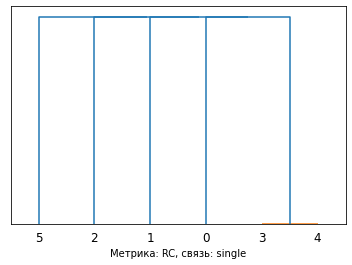

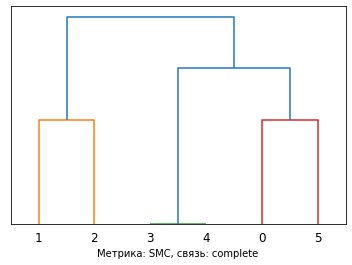

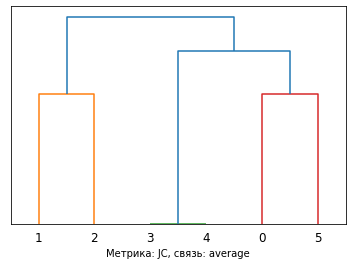

In [11]:
def coeff(x, y):
    n11 = n00 = nn = 0
    for xi, yi in zip(x, y):
        if xi == yi == 1:
            n11 += 1
        elif xi == yi == 0:
            n00 += 1
        else:
            nn += 1
    return n11, n00, nn


def SMC(x, y):
    n11, n00, nn = coeff(x, y)
    return (n11 + n00) / (n11 + n00 + nn)

def JC(x, y):
    n11, n00, nn = coeff(x, y)
    return n11 / (n11 + nn)

def RC(x, y):
    n11, n00, nn = coeff(x, y)
    return n11 / (n11 + n00 + nn)

for metric, linkage in zip([RC, SMC, JC], ['single', 'complete', 'average']):
    cluster = AgglomerativeClustering(affinity=lambda x: pairwise_distances(x, metric=metric), linkage=linkage, distance_threshold=0, n_clusters=None)
    cluster.fit(frame)
    plot_dendrogram(cluster, label=f"Метрика: {metric.__name__}, связь: {linkage}")